In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import sys
sys.path.append('../')

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch

from src.models.unet import UNet
from src.config import SEED, DEVICE
from src.utils.random import set_seed
from src.utils.visualisations import plot_pre_post_mask
from src.unet.unet_train import get_model, get_dataloaders

DATA_PATH = '../data/'
MODELS_PATH = f'{DATA_PATH}models/'

set_seed(SEED)

In [89]:
model_save_path = f'{MODELS_PATH}UNet_AdamWoptim_50epochs_0.0001lr_BCEWithLogitsLossloss_ReLUact_0.0dropout_2accstep_100evalstep_6-16-16-16-32-32-32-64-64-64-64-128-128-128encchan_256-128-128-64-128-64-64-32-64-32-16-32-16-1decchan.pth'
model = get_model()
model.load_state_dict(torch.load(model_save_path))
model.eval()

train_loader, val_loader, test_loader = get_dataloaders()

✅ Created SeededDataLoader with seed 42.
✅ Train dataloader length: 67
✅ Test dataloader length: 14
✅ Val dataloader length: 15


In [90]:
# Get class weights for binary masks
from tqdm import tqdm

class_weights = torch.tensor([1., 1.])

for batch in tqdm(train_loader):
    pre, post, mask, label = batch
    n_zero = torch.sum(mask == 0)
    n_one = torch.sum(mask == 1)
    class_weights[0] += n_zero
    class_weights[1] += n_one

pos_weight = class_weights[0] / class_weights[1]
pos_weight

  0%|          | 0/67 [00:00<?, ?it/s]

100%|██████████| 67/67 [00:06<00:00, 11.09it/s]


tensor(32.3177)

In [91]:
# Load train example
train_it = iter(train_loader)

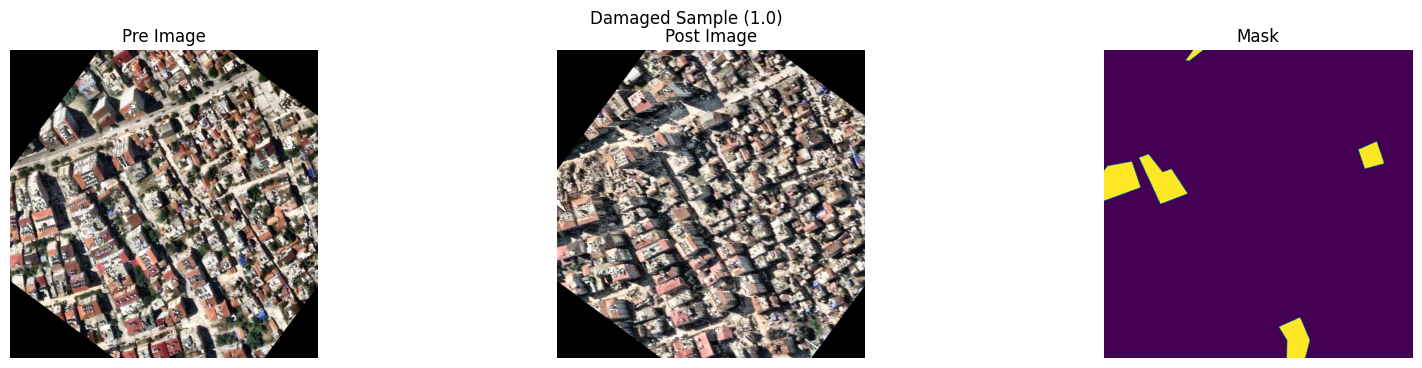

In [92]:
pres, posts, masks, labels = next(train_it)

pre = pres[0]
post = posts[0]
mask = masks[0]
label = labels[0]

plot_pre_post_mask(pre, post, mask, label, is_normalised=True)

✅ Created SeededDataLoader with seed 42.
✅ Train dataloader length: 67
✅ Test dataloader length: 14
✅ Val dataloader length: 15
torch.Size([3, 1024, 1024]) torch.Size([3, 1024, 1024]) torch.Size([1024, 1024]) torch.Size([]) torch.Size([1024, 1024])


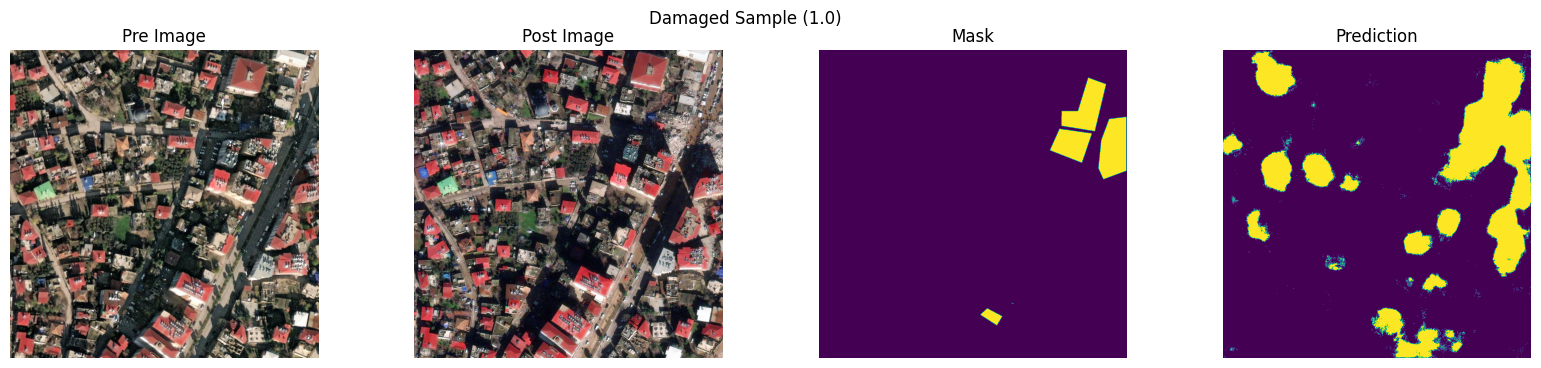

In [93]:
# Load validation example
train_loader, val_loader, test_loader = get_dataloaders()
it = iter(test_loader)
pres, posts, masks, labels = next(it)

pre = pres[0].unsqueeze(0).to(DEVICE)
post = posts[0].unsqueeze(0).to(DEVICE)
mask = masks[0].cpu()
label = labels[0]

# Get Prediction
pred = model(pre, post).squeeze()
pred = torch.nn.Sigmoid()(pred).cpu().detach()
pred = (pred > 0.5).float()

# Plot example
pre = pre.squeeze(0).cpu().detach()
post = post.squeeze(0).cpu().detach()
print(pre.shape, post.shape, mask.shape, label.shape, pred.shape)
plot_pre_post_mask(pre, post, mask, label, pred=pred, is_normalised=True)